# Conflict Impact Analysis in Middle East, North Africa, Pakistan and Afghanistan

This analysis looks at conflicts between 2020 and 2024 in MENA + AP countries. Using ACLED data, we visualize number of events, conflict and conflict intensity index. 

In [3]:
%reload_ext autoreload
%autoreload 2

import os
import acled_conflict_analysis as acled
from acled_conflict_analysis import visuals
from acled_conflict_analysis import processing
from acled_conflict_analysis import extraction


from bokeh.plotting import show, output_notebook

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
from bokeh.models import Panel, Tabs, TabPanel

from datetime import date
from datetime import datetime
import geopandas as gpd


In [4]:
countries_of_interest = [
    "Afghanistan","Pakistan","Algeria","Morocco","Libya","Yemen","Iran", "Iraq",
    "Syria","Egypt","Lebanon","Djibouti","United Arab Emirates","Jordan","Israel","Palestine",
    "Oman", "Malta", "Qatar", "Saudi Arabia", "Kuwait", "Tunisia", "Bahrain"]
START_DATE = "2020-01-01"
END_DATE = "2024-12-31"

In [5]:
os.environ['ACLED_EMAIL'] = extraction.get_acled_credentials()[0]
os.environ['ACLED_KEY'] = extraction.get_acled_credentials()[1]

In [ ]:
data = extraction.acled_api(
    email_address=os.environ.get("ACLED_EMAIL"),
    access_key=os.environ.get("ACLED_KEY"),
    countries=countries_of_interest,
    start_date=START_DATE,
    end_date=END_DATE
)

c:\WBG\Anaconda3\envs\acled\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.acleddata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [7]:
processing.data_type_conversion(data)

In [50]:
conflict_national = processing.get_acled_by_group(data, columns=['country'], freq='YS')
conflict_national = conflict_national.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()

data_no_protest = data[data['event_type'] != 'Protests']
conflict_national_no_protest = processing.get_acled_by_group(data_no_protest, columns=['country'], freq='YS')
conflict_national_no_protest = conflict_national_no_protest.groupby(['country'])[['nrEvents', 'nrFatalities']].sum().reset_index()

## Highest Fatalities

In [159]:
def plot_conflict_metrics_by_country(
    data: pd.DataFrame,
    metrics_to_plot: list,
    metric_display_info: dict = None,
    sorting_metric: str = None,
    overall_title: str = 'Comparison of Metrics by Country',
    source_text: str = None # New parameter for the source subtitle
) -> alt.Chart:
    """
    Generates a horizontally concatenated bar chart for specified metrics by country,
    with text labels for values and an optional source subtitle.

    Args:
        data (pd.DataFrame): The input DataFrame containing 'country' and metric columns.
        metrics_to_plot (list): A list of column names (metrics) to visualize.
        metric_display_info (dict, optional): A dictionary mapping metric names to
            dictionaries with 'title' and 'color' keys.
            Example: {'nrFatalities': {'title': 'Fatalities', 'color': 'steelblue'}}.
            Defaults to None, which will use metric name as title and grey color.
        sorting_metric (str, optional): The name of the metric (column) to use for
            sorting countries on the y-axis. If None, no specific sort is applied
            other than the default DataFrame order.
        overall_title (str, optional): The main title for the concatenated chart.
        source_text (str, optional): Text to be displayed as a subtitle at the bottom,
            typically used for data source information. Defaults to None.

    Returns:
        alt.Chart: An Altair Chart object representing the combined horizontal bar chart.
    """

    if metric_display_info is None:
        metric_display_info = {}

    # Sort the data if a sorting_metric is provided
    if sorting_metric and sorting_metric in data.columns:
        # Check if sorting_metric is numeric to sort in descending order
        if pd.api.types.is_numeric_dtype(data[sorting_metric]):
            data_sorted = data.sort_values(by=sorting_metric, ascending=False).reset_index(drop=True)
            # Use alt.EncodingSortField for robust sorting in Altair
            sort_order = alt.EncodingSortField(field=sorting_metric, op="min", order='descending')
        else:
            data_sorted = data.copy() # No specific sort if not numeric
            sort_order = None # Default sort for categorical data
        print(f"Sorting countries by '{sorting_metric}' in descending order.")
    else:
        data_sorted = data.copy()
        sort_order = None
        if sorting_metric:
            print(f"Warning: Sorting metric '{sorting_metric}' not found or not used for sorting.")

    charts_list = []

    for i, metric in enumerate(metrics_to_plot):
        if metric not in data_sorted.columns:
            print(f"Warning: Metric '{metric}' not found in the DataFrame and will be skipped.")
            continue

        # Get custom title and color, or use defaults
        display_info = metric_display_info.get(metric, {})
        metric_title = display_info.get('title', metric)
        metric_color = display_info.get('color', 'grey') # Default color if not specified

        # Define the Y-axis encoding, applying the dynamic sort
        y_encoding = alt.Y('country', title='Country' if i == 0 else '')
        if sort_order:
            y_encoding = alt.Y('country', sort=sort_order, title='Country' if i == 0 else '')


        # Create the Bar Layer for the current metric
        bars = alt.Chart(data_sorted).mark_bar(color=metric_color).encode(
            y=y_encoding,
            x=alt.X(metric, title=f'Number of {metric_title}')
        )

        # Create the Text Layer for the current metric
        text = alt.Chart(data_sorted).mark_text(
            align='left',
            baseline='middle',
            dx=3
        ).encode(
            y=y_encoding, # Use the same Y-encoding as bars for consistency
            x=alt.X(metric),
            text=alt.Text(metric),
            color=alt.value('black')
        )

        # Combine Bar Chart and Text Layer for the current metric
        chart = (bars + text).properties(
            title=f'{metric_title} by Country'
        )
        charts_list.append(chart)

    if not charts_list:
        return "No charts could be generated. Check your metrics and data."

    # Combine All Charts into a Subplot
    # Add subtitle here using the 'subtitle' property within the title dictionary
    combined_chart = alt.hconcat(*charts_list).resolve_scale(
        y='shared' # Ensure the y-axis (countries) is shared across all charts
    ).properties(
        title={
            "text": overall_title,
            "subtitle": source_text if source_text else "" # Use source_text as subtitle
        }
    )

    return combined_chart

plot_conflict_metrics_by_country(
    data =conflict_national,
    metrics_to_plot =['nrFatalities', 'nrEvents'],
    metric_display_info = {'nrFatalities': {'title': 'Fatalities', 'color': 'steelblue'},
                           'nrEvents': {'title': 'Events', 'color': 'orange'}},
    sorting_metric = 'nrFatalities',
    overall_title = 'Comparison of Conflict Metrics by Country',
    source_text = f'Source: ACLED. Accessed: {str(date.today())}'
)

Sorting countries by 'nrFatalities' in descending order.


alt.HConcatChart(...)

In [110]:
highest_15 = conflict_national[['country', 'nrFatalities']].sort_values(by='nrFatalities', ascending=False).head(15).reset_index(drop=True)['country'].tolist()

In [34]:
# Import the function from your .py file
from boundaries_utils import load_country_boundaries_to_dict

# Define your parameters
# my_countries = countries_of_interest
# my_adm_level = 0 # For country boundaries
# my_output_folder = "../../data/boundaries" # Path to your downloaded data

# Call the function to load the boundaries into a dictionary
boundaries_adm0 = load_country_boundaries_to_dict(
        country_names_to_load=countries_of_interest,
        target_adm_level=0,
        output_base_folder='../../data/boundaries'
    )

boundaries_adm1 = load_country_boundaries_to_dict(
        country_names_to_load=countries_of_interest,
        target_adm_level=1,
        output_base_folder='../../data/boundaries'
    )


INFO: 
--- Creating dictionary: country_name -> boundary_gdf (ADM0) ---
INFO: Loading boundary data for 'Afghanistan' (ADM0) from: ..\..\data\boundaries\AFG_ADM0_gbOpen.geojson
INFO: Successfully loaded Afghanistan (ADM0) as GeoDataFrame.
INFO: Loading boundary data for 'Pakistan' (ADM0) from: ..\..\data\boundaries\PAK_ADM0_gbOpen.geojson
INFO: Successfully loaded Pakistan (ADM0) as GeoDataFrame.
INFO: Loading boundary data for 'Algeria' (ADM0) from: ..\..\data\boundaries\DZA_ADM0_gbOpen.geojson
INFO: Successfully loaded Algeria (ADM0) as GeoDataFrame.
INFO: Loading boundary data for 'Morocco' (ADM0) from: ..\..\data\boundaries\MAR_ADM0_gbOpen.geojson
INFO: Successfully loaded Morocco (ADM0) as GeoDataFrame.
INFO: Loading boundary data for 'Libya' (ADM0) from: ..\..\data\boundaries\LBY_ADM0_gbOpen.geojson
INFO: Successfully loaded Libya (ADM0) as GeoDataFrame.
INFO: Loading boundary data for 'Yemen' (ADM0) from: ..\..\data\boundaries\YEM_ADM0_gbOpen.geojson
INFO: Successfully loaded Ye

In [ ]:
boundaries_h3_7 = {}
for country in boundaries_adm0.keys():
    boundaries_h3_7[country] = processing.convert_to_h3_grid(boundaries_adm0[country], resolution=7)

In [97]:
boundaries_h3_4 = {}
for country in boundaries_adm0.keys():
    boundaries_h3_4[country] = processing.convert_to_h3_grid(boundaries_adm0[country], resolution=4)


In [99]:
import pandas as pd
boundaries_h3_4_df = pd.DataFrame()
for country in boundaries_h3_7.keys():
    boundaries_h3_4_df = pd.concat([boundaries_h3_4_df, boundaries_h3_4[country]])
    

In [40]:
import pandas as pd
boundaries_h3 = pd.DataFrame()
for country in boundaries_h3_7.keys():
    boundaries_h3 = pd.concat([boundaries_h3, boundaries_h3_7[country]])
    

In [105]:
conflict_yearly_h3 = processing.get_acled_by_admin(boundaries_h3_4_df, data, columns=['h3_index', 'country'], freq='YS')
conflict_national_h3 = conflict_yearly_h3.groupby(['country', 'h3_index'])[['nrEvents', 'nrFatalities']].sum().reset_index()
conflict_national_h3 = conflict_national_h3.merge(boundaries_h3_4_df[['h3_index', 'geometry']], on='h3_index', how='left')
conflict_national_h3 = processing.calculate_conflict_index(conflict_national_h3)
conflict_national_h3= gpd.GeoDataFrame(conflict_national_h3, crs='EPSG:4326', geometry='geometry')

In [77]:
import pandas as pd
boundaries_adm1_df = pd.DataFrame()
for country in boundaries_adm1.keys():
    boundaries_adm1_df = pd.concat([boundaries_adm1_df, boundaries_adm1[country]])
    

In [81]:
conflict_adm1 = processing.get_acled_by_admin(boundaries_adm1_df, data, columns=['shapeName', 'country'], freq='YS')
conflict_adm1 = conflict_adm1.groupby(['country', 'shapeName'])[['nrEvents', 'nrFatalities']].sum().reset_index()
conflict_adm1 = conflict_adm1.merge(boundaries_adm1_df[['shapeName', 'geometry']], on='shapeName', how='left')
conflict_adm1 = processing.calculate_conflict_index(conflict_adm1)
conflict_adm1 = gpd.GeoDataFrame(conflict_adm1, crs='EPSG:4326', geometry='geometry')

## Geospatial Distribution of Conflict Intensity

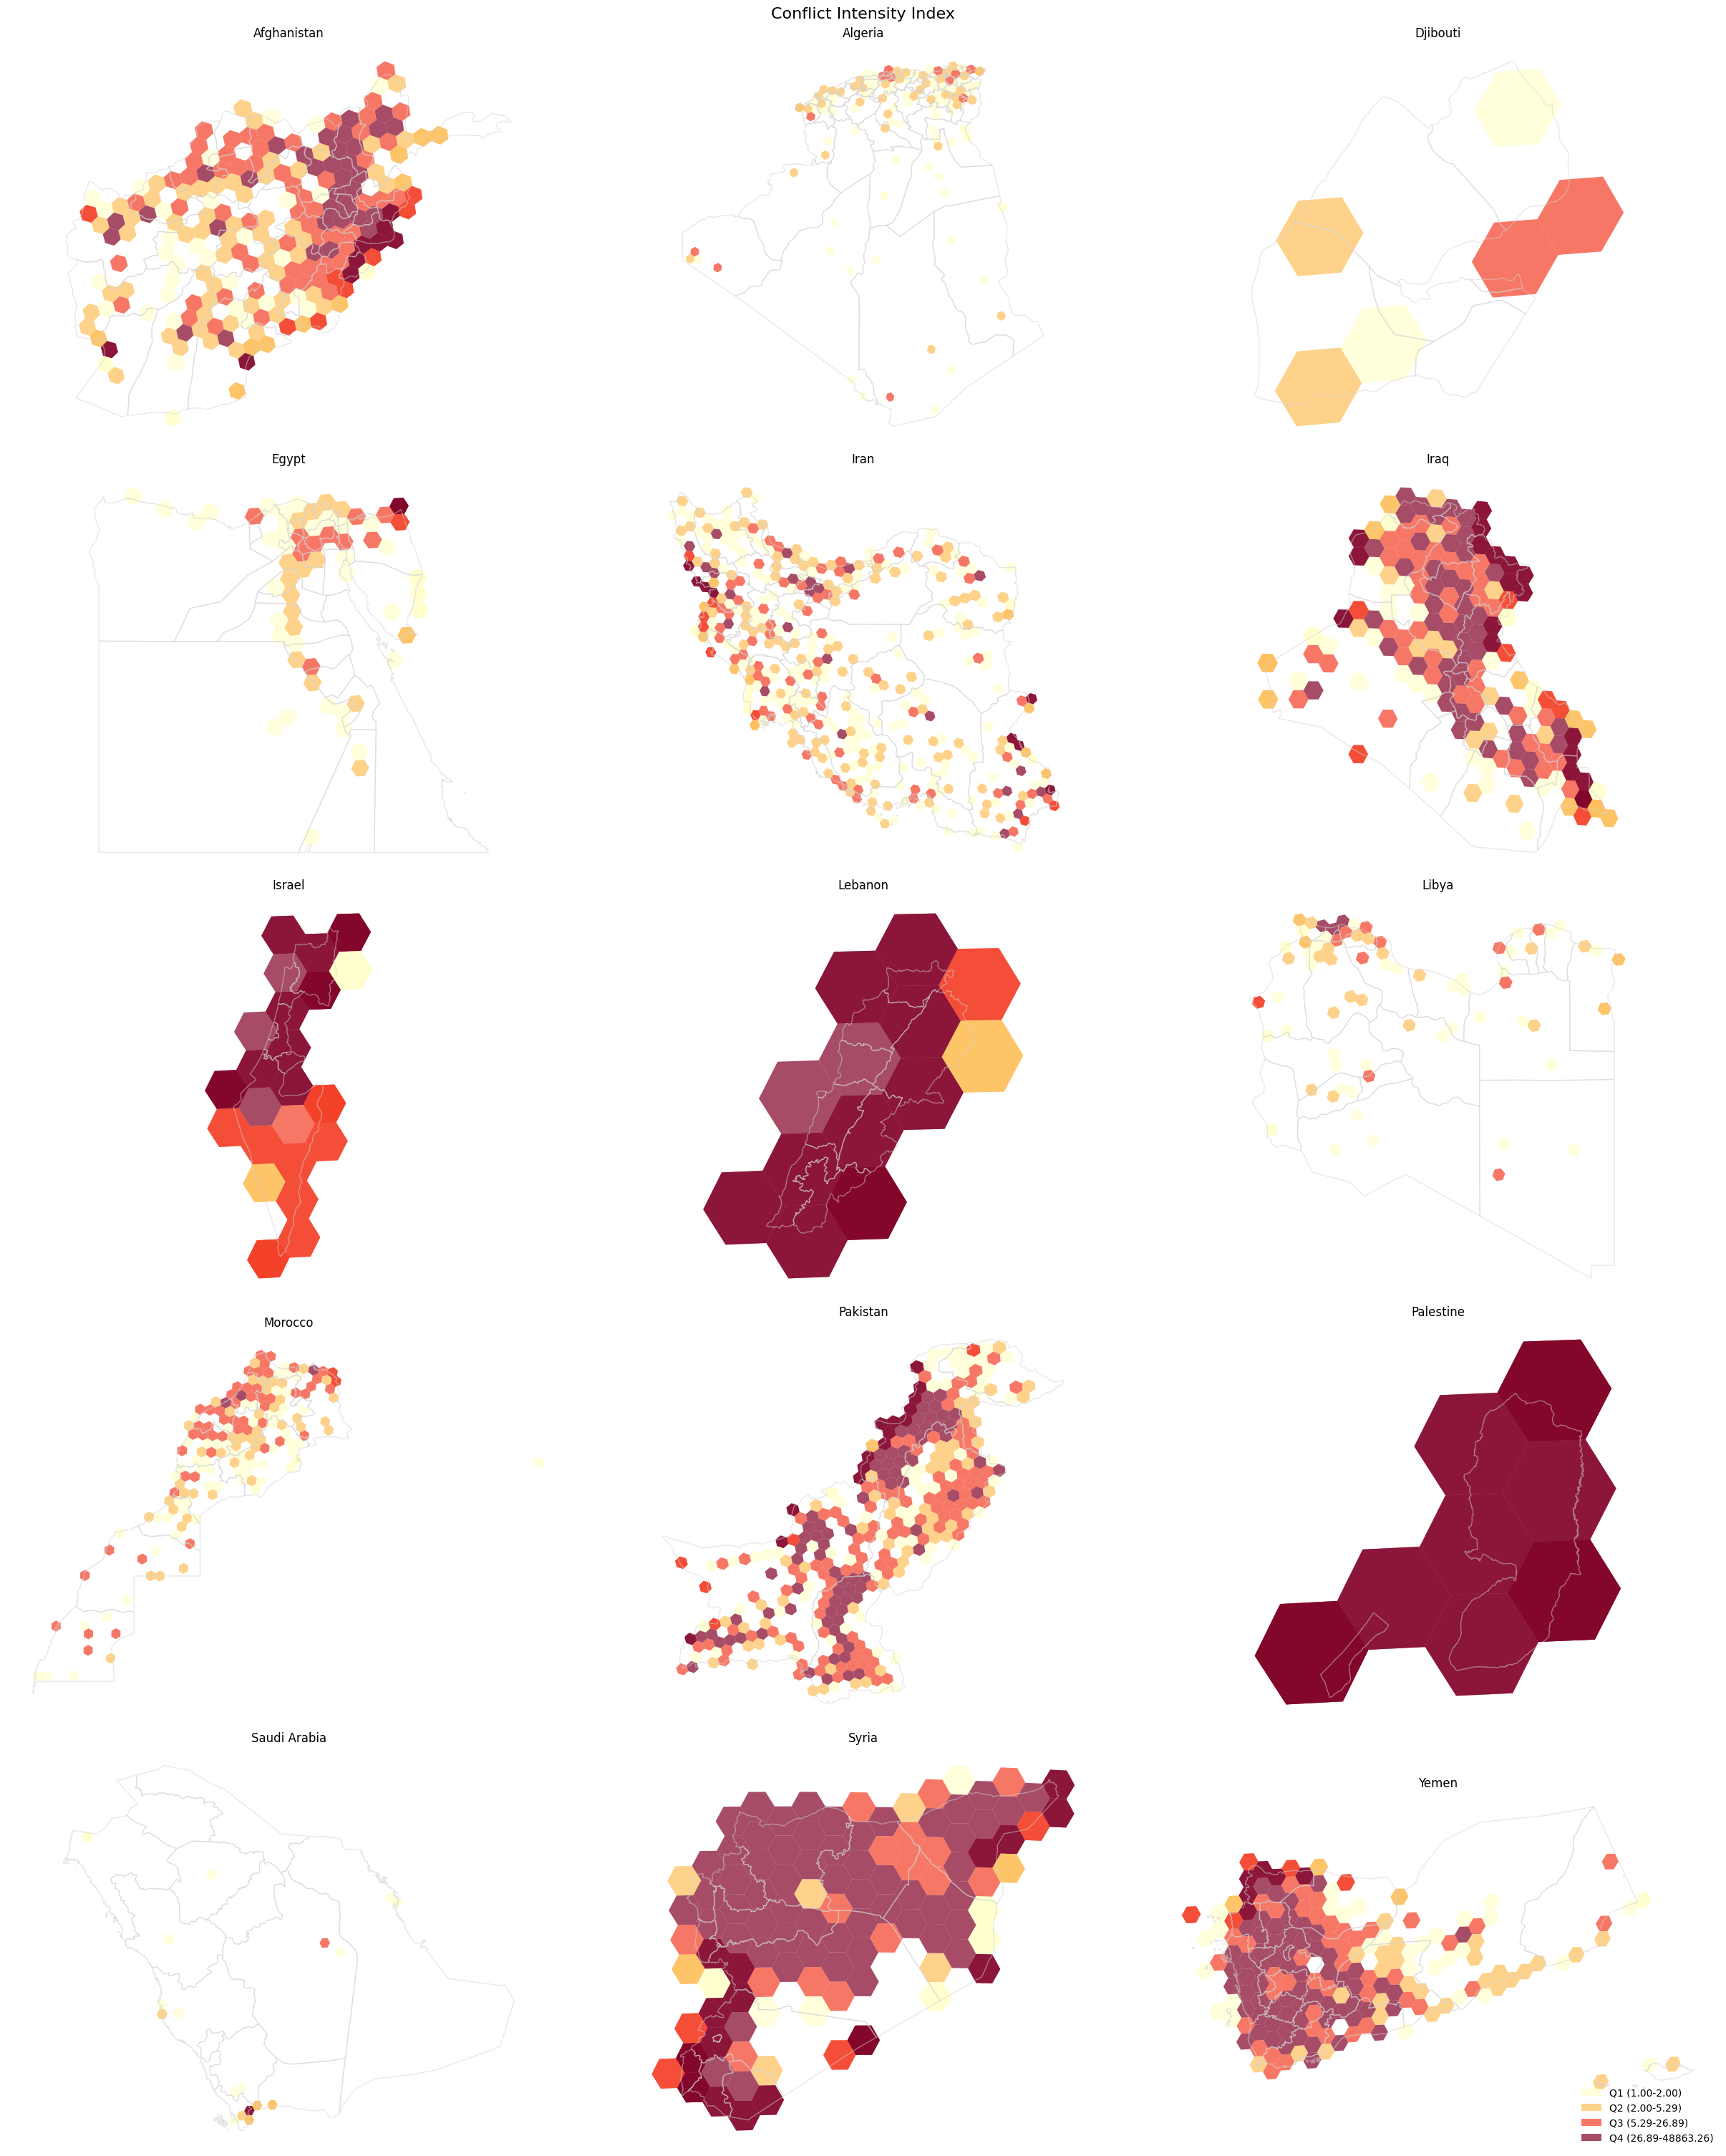

In [111]:
visuals.plot_h3_maps_by_column_value(
    conflict_national_h3[conflict_national_h3['country'].isin(highest_15)],
    title='Conflict Intensity Index',
    column_name='country',
    measure='conflict_intensity_index',
    cmap_name='YlOrRd',
    boundary_gdfs_map=boundaries_adm1,
    subtitle_prefix='');

In [165]:
conflict_event_monthly = processing.get_acled_by_group(data, columns=['country', 'event_type'], freq='MS')

### Which country saw the most widespread conflict?

1. We divided each country into ~5km grids
2. Every grid that had atleast one fatality/events was counted
3. Percentage of area where conflict occured is calculated

In [118]:
conflict_yearly_h3_7 = processing.get_acled_by_admin(boundaries_h3, data, columns=['h3_index', 'country'], freq='YS')
conflict_national_h3_7 = conflict_yearly_h3.groupby(['country', 'h3_index'])[['nrEvents', 'nrFatalities']].sum().reset_index()
conflict_national_h3_7 = conflict_national_h3_7.merge(boundaries_h3[['h3_index', 'geometry']], on='h3_index', how='left')
conflict_national_h3_7 = processing.calculate_conflict_index(conflict_national_h3_7)
conflict_national_h3_7= gpd.GeoDataFrame(conflict_national_h3_7, crs='EPSG:4326', geometry='geometry')

In [132]:
country_grids ={}
for country in boundaries_h3_7.keys():
    country_grids[country] = boundaries_h3_7[country].shape[0]

country_grids_df = pd.DataFrame.from_dict(country_grids, orient='index', columns=['nrGrids']).reset_index().rename(columns={'index': 'country'})

In [146]:
import numpy as np

def get_spread(conflict_national_h3_7, metric):
    conflict_spread = conflict_national_h3_7[conflict_national_h3_7[metric]>0].groupby('country')['h3_index'].count().sort_values(ascending=False).reset_index().rename(columns={'h3_index': 'nrGridsWithFatalities'})

    conflict_spread = conflict_spread.merge(country_grids_df, on='country')
    conflict_spread['conflictArea'] = np.round(100*conflict_spread['nrGridsWithFatalities'] / conflict_spread['nrGrids'],2)

    return conflict_spread

In [147]:
conflict_spread_fatalities = get_spread(conflict_national_h3_7, 'nrFatalities')
conflict_spread_events = get_spread(conflict_national_h3_7, 'nrEvents')

In [ ]:
conflict_spread_events.rename(columns={'conflictArea': 'conflictAreaEvents'}, inplace=True)
conflict_spread_fatalities.rename(columns={'conflictArea': 'conflictAreaFatalities'}, inplace=True)
conflict_spread = conflict_spread_events.merge(conflict_spread_fatalities, on='country')

In [162]:
plot_conflict_metrics_by_country(
    data =conflict_spread,
    metrics_to_plot =['conflictAreaFatalities', 'conflictAreaEvents'],
    metric_display_info = {'conflictAreaFatalities': {'title': '% Area with Fatalities', 'color': 'steelblue'},
                           'conflictAreaEvents': {'title': '% Area with Events', 'color': 'orange'}},
    sorting_metric = 'conflictAreaFatalities',
    overall_title = 'Comparison of Conflict Metrics by Country',
    source_text = f'Source: ACLED. Accessed: {str(date.today())}'
)

Sorting countries by 'conflictAreaFatalities' in descending order.


alt.HConcatChart(...)

## Conflict Type Trends

In [176]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.models import TabPanel, Tabs # Panel is deprecated in newer Bokeh
from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
import bokeh.core.validation # Import the module to access silence
bokeh.core.validation.silence(MISSING_RENDERERS, True)
bokeh.core.validation.silence(EMPTY_LAYOUT, True) # Added for completeness if this also occurs

output_notebook() # Ensure this is called if running in a notebook environment



tabs = []

measures = countries_of_interest

conflict_event_monthly = conflict_event_monthly.sort_values(by=['country', 'event_type'])

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        conflict_event_monthly[conflict_event_monthly['country'] == measure],
        title = f'{measure} Monthly Conflict Events',
        source="Source: Sentinel 5-P extracted from Google Earth Engine",
        category='event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...

In [177]:

output_notebook() # Ensure this is called if running in a notebook environment



tabs = []

measures = countries_of_interest

conflict_event_monthly = conflict_event_monthly.sort_values(by=['country', 'event_type'])
df = conflict_event_monthly[conflict_event_monthly['event_type']!='Protests']

for idx, measure in enumerate(measures):
    # Get the line plot using the provided visuals_module
    p = visuals.get_line_plot(
        df[df['country'] == measure],
        title = f'{measure} Monthly Conflict Events (without Protests)',
        source="Source: Sentinel 5-P extracted from Google Earth Engine",
        category='event_type',
        measure='nrEvents',
        event_date='event_date'
    )

    tab = TabPanel(child=p, title=measure)
    tabs.append(tab)

# Show the plot with tabs
bokeh_tabs_display = Tabs(tabs=tabs, sizing_mode="scale_both")
show(bokeh_tabs_display, warn_on_missing_glyphs=False)

Loading BokehJS ...

## Impact on Population

{wip}
